# Module 5: Interpolation and Regression (Curve Fitting)

***Task:*** Given points
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Interpolation_Data.svg/300px-Interpolation_Data.svg.png)

we want to recover a function. For example, piecewise constant interpolation, or nearest-neighbor interpolation gives

![!](https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Piecewise_constant.svg/300px-Piecewise_constant.svg.png)

or linear spline interpolation --
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Interpolation_example_linear.svg/300px-Interpolation_example_linear.svg.png)

or polynomial interpolation 
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Interpolation_example_polynomial.svg/300px-Interpolation_example_polynomial.svg.png)


## Polynomial interpolation via [Lagrange Interpolation](https://dlmf.nist.gov/3.3)

Given set of points x_given = $\{x_k\}_{k=0}^{n}$ and the value of the function at these points f_given = $\{f_k = f(x_k)\}_{k=0}^{n}$, the Lagrange interpolation polynomial $P_n(x)$ reads
$$
	P_n(x) = \sum_{k=0}^n l_k(x) f_k,
$$
where
$$
	l_k(x) = \prod_{j=0, \atop j\neq k}^n \frac{x - x_j}{x_k - x_j}.
$$

In [1]:
function lagrange_interp(x_given, f_given, x_eval)
    
    # consistency check
    @assert length(x_given) == length(f_given)
    
    P = zeros(length(x_eval))
    
    for k = 1:length(x_given)
       lₖ = ones(length(x_eval))
        
        for j = 1:length(x_given)
            if j ≠ k
               lₖ .*= (x_eval .- x_given[j]) ./ (x_given[k] - x_given[j])
            end
        end
        
        P .+= lₖ * f_given[k]
    end
    
    return P
end

lagrange_interp (generic function with 1 method)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


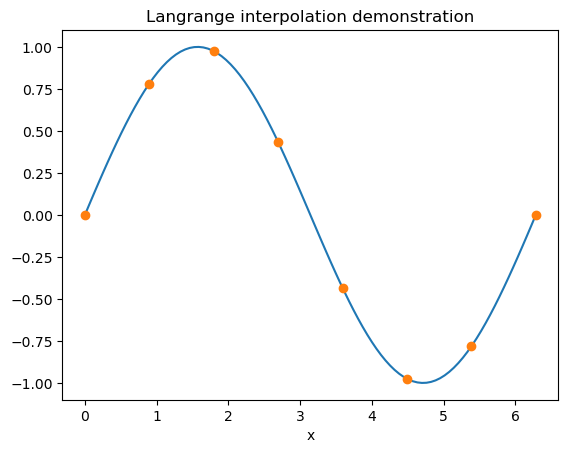

In [2]:
using PyPlot

x_given = range(0, 2 * π, 8)
f_given = sin.(x_given)

x_eval = range(0, 2 * π, 100)

title("Langrange interpolation demonstration")
plot(x_eval, lagrange_interp(x_given, f_given, x_eval))
plot(x_given, f_given, "o")
xlabel("x")
show()

## Polynomial interpolation via matrix algebra

The Lagrange interpolation polynomial can be constructed in a different way: Given the input data $\{x_k\}_{k=1}^n$ and $\{f_k = f(x_k)\}_{k=1}^n$, we need to find the coefficients $a_1, \ldots, a_n$ such that
$$
    \sum_{j=1}^n a_j x_k^{j - 1} = f_k, 
    \qquad k = 1, \ldots, n.
$$

The latter can be written as the matrix equation for the unknown vector $\begin{pmatrix} a_1 & a_2 & \ldots & a_n \end{pmatrix}^T$
$$
\underbrace{\begin{pmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^{n-1} \\
    1 & x_2 & x_2^2 & \ldots & x_2^{n-1} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^{n-1} 
\end{pmatrix}}_{\text{This is known as the Vandermonde matrix}}
\begin{pmatrix}
    a_1 \\
    a_2 \\
    \vdots \\
    a_n 
\end{pmatrix}
=
\begin{pmatrix}
    f_1 \\
    f_2 \\
    \vdots \\
    f_n 
\end{pmatrix}
$$

In [3]:
function lagrange_interp_matrix(x_given, f_given, x_eval)
    
    # consistency check
    @assert length(x_given) == length(f_given)
    
    n = length(x_given)
    
    # Step 1: get the Vandermonde matrix
    Vandermonde = ones(n, n)
    
    for j = 2:n
        Vandermonde[:, j] = x_given .* Vandermonde[:, j - 1]
        # this equivalent to
        # Vandermonde[:, j] = x_given .^ (j - 1)
    end
    
    # Step 2: get a's
    a = Vandermonde \ f_given
    
    # Step 3: Get the interpolated values
    P = zeros(length(x_eval))
    
    x_evalʲ⁻¹ = ones(length(x_eval))
    
    for j = 1:n
        P += a[j] *  x_evalʲ⁻¹
        x_evalʲ⁻¹ .*= x_eval
    end
    
    return P
end

lagrange_interp_matrix (generic function with 1 method)

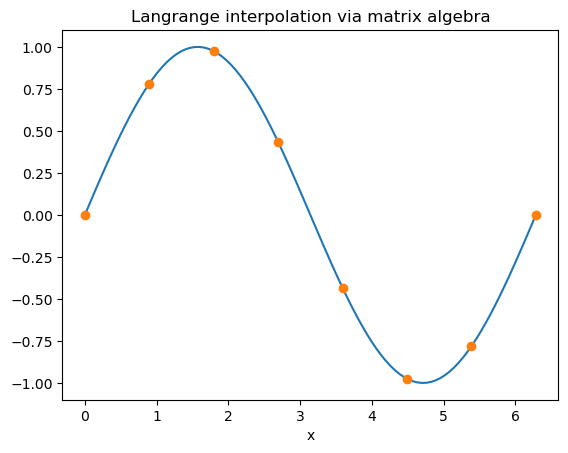

In [4]:
title("Langrange interpolation via matrix algebra")
plot(x_eval, lagrange_interp_matrix(x_given, f_given, x_eval))
plot(x_given, f_given, "o")
xlabel("x")
show()

## Not all is well -- 😱😱😱😱 [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) 😱😱😱😱

The polynomial interpolation error $\to\infty$ as $n\to\infty$ when using the equally spaced grid
$$
    f(x) = \frac{1}{\sqrt{1 + 25 x^2}},
    \qquad -1 \leq x \leq +1.
$$

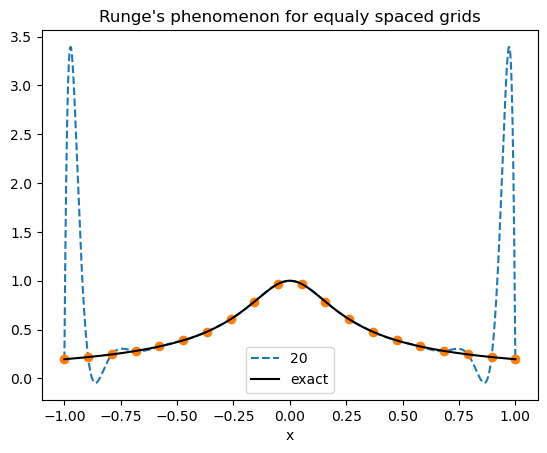

In [5]:
f(x) = 1 / sqrt(1 + 25 * x ^ 2)

x_eval = range(-1, 1, 1000)

for n = [20]#[5, 10, 15]

    x_given = range(-1, 1, n)
    
    plot(x_eval, lagrange_interp(x_given, f.(x_given), x_eval), "--", label=string(n))
    
    plot(x_given,  f.(x_given), "o")
end

title("Runge's phenomenon for equaly spaced grids")
plot(x_eval, f.(x_eval), "k", label="exact")
legend()
xlabel("x")
show()

## Orthogonal Polynomials to the rescue 🚒🚒🚒🚒🚒🚒

The coordinate grid should be chosen as the zero of an orthogonal polynomial. The [Chebyshev polynomials](https://dlmf.nist.gov/18.3) is [the best of them all](https://dlmf.nist.gov/3.11).

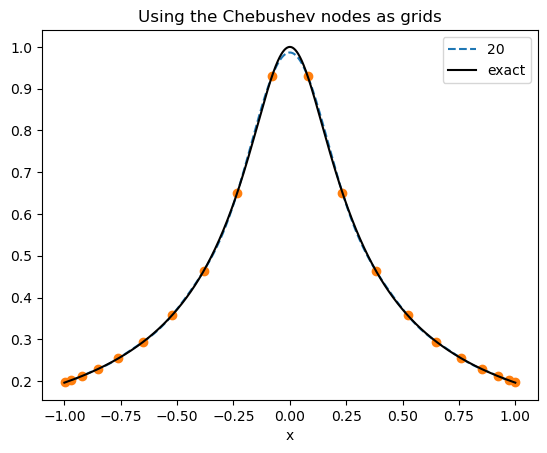

In [6]:
using FastGaussQuadrature

for n = [20]

    x_given, w = gausschebyshev(n)
    
    plot(x_eval, lagrange_interp(x_given, f.(x_given), x_eval), "--", label=string(n)) 
    
    plot(x_given,  f.(x_given), "o")
end

title("Using the Chebushev nodes as grids")
plot(x_eval, f.(x_eval), "k", label="exact")
legend()
xlabel("x")
show()

### Check out the library [Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl) and other libraries cited there for all your interpolation needs 

## Polynomial regression in 1D

Let's start with the polynomial regression in 1D.

[Regression](https://en.wikipedia.org/wiki/Regression_analysis) is a set of statistical methods for estimating the relationships between a dependent variable and one or more independent variable.

Given the input data $\{x_k\}_{k=1}^n$ and $\{f_k = f(x_k)\}_{k=1}^n$, we want to find the polynomial of the $(m-1)$-th degree $(m \leq n)$,
$$
    \sum_{j=1}^m a_j x^{j - 1}
$$
that approximates the input data. Note that when $n=m$ we recover the Lagrange interpolation polynomial

In other words, we want to find the coefficients $a_1, \ldots, a_m$ such that
$$
    \sum_{j=1}^m a_j x_k^{j - 1} \approx f_k, 
    \qquad k = 1, \ldots, n.
$$

What do we mean by ``$\approx$''? **The least sqaure error minimization**


$$
    error^2 = \sum_{k=1}^n \left(\sum_{j=1}^m a_j x_k^{j - 1} - f_k\right)^2 \to \min.
$$

The latter can be written in the following form for the unknown vector $\begin{pmatrix} a_1 & a_2 & \ldots & a_m \end{pmatrix}^T$
$$
error^2 = \left\|\mbox{$n$ rows } 
    \underbrace{\left\{\begin{pmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^{m-1} \\
    1 & x_2 & x_2^2 & \ldots & x_2^{m-1} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^{m-1} 
\end{pmatrix}\right.}_{\mbox{$m$ columns}}
\begin{pmatrix}
    a_1 \\
    a_2 \\
    \vdots \\
    a_m 
\end{pmatrix}
-
\begin{pmatrix}
    f_1 \\
    f_2 \\
    \vdots \\
    f_n 
\end{pmatrix}
\right\|_2^2 \to \min,
$$
here $\| {\bf y} \|_2^2 = \sum_{k=1}^n y_k^2$ is the ``length'' of the vector ${\bf y}$, i.e., [the vector norm](https://en.wikipedia.org/wiki/Norm_(mathematics)).

In [7]:
function poly_regression(x_given, f_given, m::Int, x_eval)
    
    # consistency check
    @assert length(x_given) == length(f_given)
    
    n = length(x_given)
    
    # Step 1: get matrix X
    X = ones(n, m)
    
    for j = 2:m
        X[:, j] = x_given .* X[:, j - 1]
        # this equivalent to
        # X[:, j] = x_given .^ (j - 1)
    end
        
    # Step 2: get a's
    a = X \ f_given
    
    # Step 3: Perform regression
    P = zeros(length(x_eval))
    
    x_evalʲ⁻¹ = ones(length(x_eval))
    
    for j = 1:m
        P += a[j] *  x_evalʲ⁻¹
        x_evalʲ⁻¹ .*= x_eval
    end
    
    return P
end

poly_regression (generic function with 1 method)

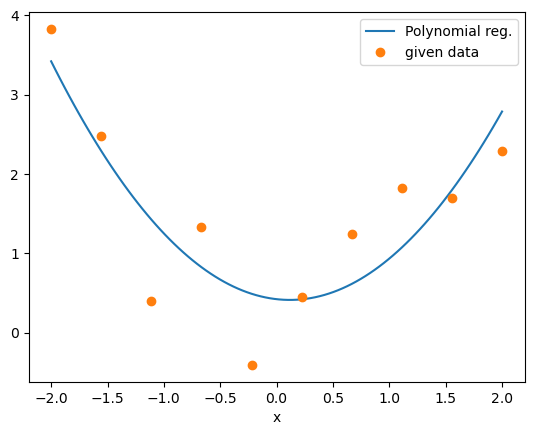

In [8]:
using Random
Random.seed!(926491)

f_exact(x) = x ^ 2

x_given = range(-2, 2, 10)
f_given = f_exact.(x_given) + randn(length(x_given))

x_eval = range(-2, 2, 100)    

plot(x_eval, poly_regression(x_given, f_given, 3, x_eval), label="Polynomial reg.")
plot(x_given, f_given, "o", label="given data")
legend()
xlabel("x")
show()